### Download Resnet-RS repository
* Get Resnet-RS models from https://github.com/nachiket273/pytorch_resnet_rs 

In [1]:
!git clone https://github.com/nachiket273/pytorch_resnet_rs.git
%cd pytorch_resnet_rs

Cloning into 'pytorch_resnet_rs'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 57 (delta 28), reused 34 (delta 12), pack-reused 0
Unpacking objects: 100% (57/57), 17.94 KiB | 633.00 KiB/s, done.
/kaggle/working/pytorch_resnet_rs


### Initial Configuration
* dataset split into train/test

In [2]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, DataLoader, ConcatDataset
from math import floor
from model.randaugment import RandAugment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_labels=[]

# Transform
transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
])

# Load Data
# Dataset folders organized according to division of classes: 

#dataset = ImageFolder('../../input/tcc-al/ML/dataset_species_224x224', transform=transform) # 20 classes -> species
dataset = ImageFolder('../../input/tcc-al/ML/dataset_families_224x224', transform=transform) # 12 classes -> families
#dataset = ImageFolder('../../input/tcc-al/ML/dataset_AE_224x224', transform=transform) # 2 classes -> A & E

# Classes info
classes = dataset.classes
num_classes = len(dataset.class_to_idx)
print(classes)
print("Número de classes: ", num_classes)

# getting the labels from all images in the dataset for stratified split
for i in range(len(dataset)):
       all_labels.append(dataset[i][1])
dataset_size = len(dataset)
print("Total de imagens: ", dataset_size)


# Set fixed random number seed
torch.manual_seed(42)
train_sets=[]
test_sets=[]

# Train/test split
# (I used 8.99 proportion instead of 0.9 for pratical reasons for this specific custom dataset)
sets=train_test_split(dataset, all_labels, test_size=0.899, 
                 random_state=42, stratify=all_labels)
test_set = sets[0]
train_set = sets[1]
print("Imagens de treino ",len(train_set), " | Imagens de teste: ", len(test_set))

# Training Configuration
k_folds = 10
num_epochs = 20
loss_function = nn.CrossEntropyLoss()
batch_size = 51

print("Batch size: ", batch_size)

dataset_kfold = train_set
print("------------------------")

['Apocynaceae', 'Caryocaraceae', 'Celastraceae', 'Clusiaceae', 'Fabaceae', 'Lythraceae', 'Malvaceae', 'Melastomataceae', 'Myrtaceae', 'Ochnaceae', 'Styracaceae', 'Vochysiaceae']
Número de classes:  12
Total de imagens:  1039
Imagens de treino  935  | Imagens de teste:  104
Batch size:  51
------------------------


## Training Function

In [3]:
def train_epoch(model, trainloader, validloader, optimizer, loss_function, divide, classes):
    # Begin training the model (1 epoch)
    print_every = divide
    current_loss = 0
    train_losses, valid_losses = [], []
    valid_accuracy = []
    classes_accuracies =[]
    step=0
    epoch_true = []
    epoch_pred = []
    for inputs, labels in trainloader:
        step = step+1
            
        # Get inputs
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = loss_function(outputs, labels) 
        loss.backward() #Backpropagation
        optimizer.step() #Gradient Descend
        
        current_loss += loss.item() 
        
        if step % print_every == 0:
            valid_loss = 0
            accuracy = 0
            local_acc = 0
            pred = []
            true = []

            class_accuracy = {classname: 0 for classname in classes}
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = loss_function(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    _, predictions = (torch.max(ps, 1))
                    pred=predictions.tolist() 
                    true=labels.tolist()
                    target_names = classes
                    
                    true_acc = np.array(true)
                    pred_acc = np.array(pred)
                    
                    cm = confusion_matrix(true, pred)
                    cm = cm.astype('float') / cm.sum(axis=1)

                    diagonal = cm.diagonal()
                    for classname in classes:
                        c = classes.index(classname)

                        class_trues = ((pred_acc == true_acc) * (true_acc == c)).sum()

                        class_total = (true_acc == c).sum()

                        if class_total == 0:
                            class_accuracy[classname] = 0
                        else:
                            class_accuracy[classname] = class_trues / class_total
                            
                    epoch_true += true
                    epoch_pred += pred
                    classes_accuracies.append(class_accuracy.copy())
     
            train_losses.append(current_loss/print_every)
            valid_losses.append(valid_loss/len(validloader))
            valid_accuracy.append(accuracy/len(validloader))
            
             #Print loss and accuracy every epoch
            #print(f"Epoch {epoch+1}... "
                #f"Train loss: {current_loss/print_every:.3f}.. "
                #f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                #f"Valid accuracy: {accuracy/len(validloader):.3f}")
            current_loss = 0
            model.train()

    return train_losses, valid_losses, classes_accuracies;
            

### Getting the model
* the name *restart_network()* is used for the intended function, while the other has the name changed to *restart_network2()* to avoid conflict

In [4]:
# resnetrs NO pre-training

from model import ResnetRS

def restart_network2():

    cfg = ResnetRS._get_cfg('resnetrs152')

    resnetrs = ResnetRS.create_model(cfg['block'], cfg['layers'], num_classes=num_classes, in_ch=3,
                         stem_width=batch_size, down_kernel_size=1,
                         actn=cfg['actn'],
                         norm_layer=cfg['norm_layer'], 
                         seblock=cfg['seblock'],
                         reduction_ratio=cfg['reduction_ratio'], 
                         dropout_ratio=cfg['dropout_ratio'],
                         stochastic_depth_rate=cfg['stochastic_depth_rate'],
                         zero_init_last_bn=cfg['zero_init_last_bn'])
    model = resnetrs
    model.to(device)
    return model

In [5]:
#resnetrs pre-trained
print("--> RESNET-RS-101 - PRETRAINED <--")
from model import ResnetRS

def restart_network():

    resnetrs = ResnetRS.create_pretrained('resnetrs101',in_ch=3, num_classes=num_classes,
                           drop_rate=0.25)
    model = resnetrs
    model.to(device)
    return model

--> RESNET-RS-101 - PRETRAINED <--


## Testing Functions
* Predict image function (test the network classification of a single image)
* Testing function (the network in this function is tested with multiple images - with weighted distribution for umbalanced datasets)

In [6]:
from torch.autograd import Variable

def predict_image(image, modelo_teste):
    test_transforms = T.Compose([T.Resize(224),
                                 T.ToTensor(),])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    modelo_teste.eval()
    output = modelo_teste(input)
    index = output.data.cpu().numpy().argmax()
    return index


In [7]:
from torch.utils.data.sampler import WeightedRandomSampler

def test(modelo, classes):
    pred_final =[]
    data = test_set
    to_pil = T.ToPILImage()
    indices = list(range(len(data)))
    img_test = [data[i][1] for i in indices]

    class_sample_count = np.array(
    [len(np.where(img_test == t)[0]) for t in np.unique(img_test)])
    #print("class_sample_count: ", class_sample_count)

    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in img_test])
    
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    #print("samples_weigth: ", samples_weigth)
    
    # Weighted sampler for proportional distribution of classes, no replacement
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=False)
    loader = torch.utils.data.DataLoader(data, 
                       sampler=sampler, batch_size=batch_size)
    
    dataiter = iter(loader)
    images, labels = dataiter.next()

    for k in range(len(images)):
        image = to_pil(images[k])
        pred = predict_image(image, modelo)
        pred_final.append(pred)
    return labels, pred_final

## k-fold training
* Training loop
* Generate loss graph, accuracy graph and testing results (including confusion matrix) for every fold  

--------------------------------
FOLD 0


Downloading: "https://github.com/nachiket273/pytorch_resnet_rs/releases/download/v.0.0.1/resnetrs101_7c6d6621.pth" to /root/.cache/torch/hub/checkpoints/resnetrs101_7c6d6621.pth
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


-> Training Results for Fold - 0
Classes Accuracies:


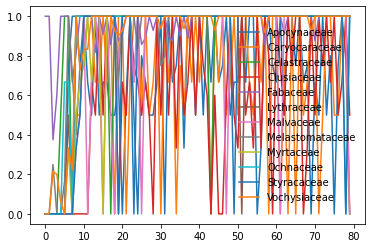

 Loss Curves:


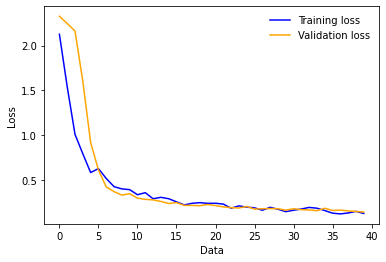

-> Test Results for Fold - 0


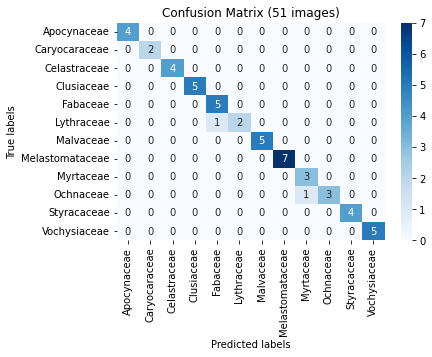

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  66.66666666666666 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  75.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  0  Test Accuracy:  96.07843137254902 %
--------------------------------
FOLD 1
-> Training Results for Fold - 1
Classes Accuracies:


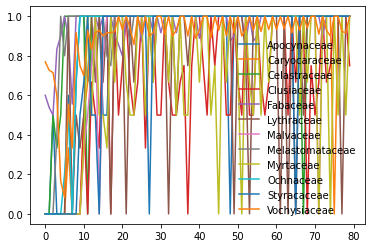

 Loss Curves:


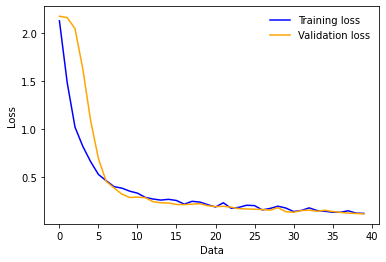

-> Test Results for Fold - 1


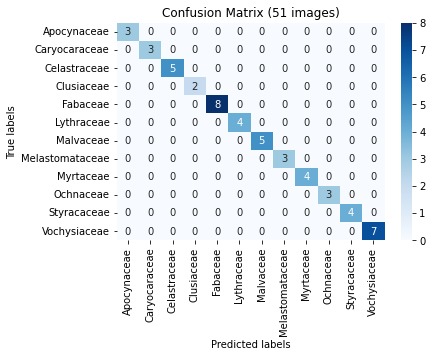

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  100.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  100.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  1  Test Accuracy:  100.0 %
--------------------------------
FOLD 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:138: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


-> Training Results for Fold - 2
Classes Accuracies:


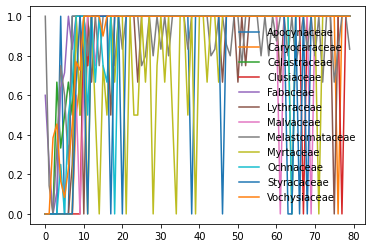

 Loss Curves:


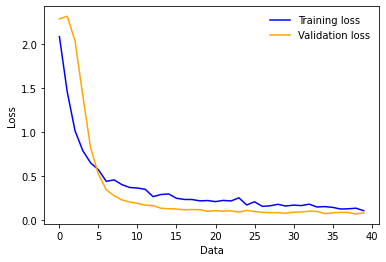

-> Test Results for Fold - 2


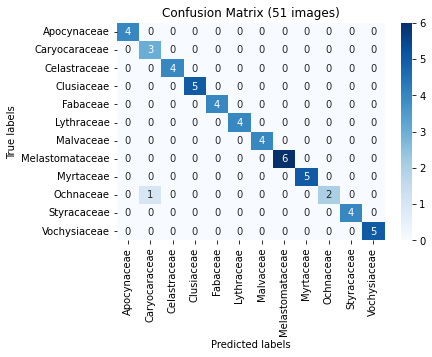

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  100.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  66.66666666666666 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  2  Test Accuracy:  98.0392156862745 %
--------------------------------
FOLD 3
-> Training Results for Fold - 3
Classes Accuracies:


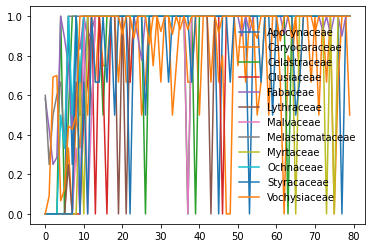

 Loss Curves:


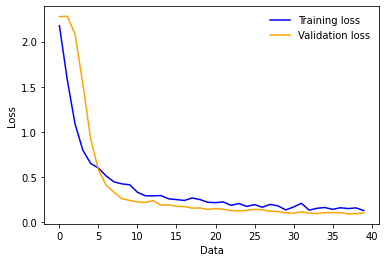

-> Test Results for Fold - 3


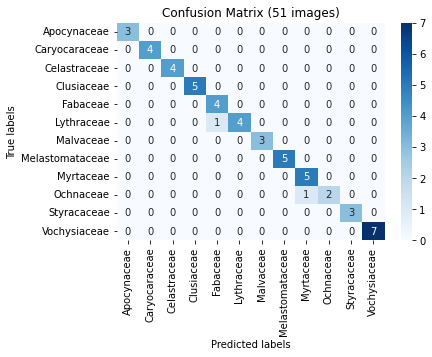

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  80.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  66.66666666666666 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  3  Test Accuracy:  96.07843137254902 %
--------------------------------
FOLD 4
-> Training Results for Fold - 4
Classes Accuracies:


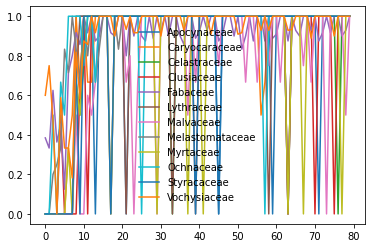

 Loss Curves:


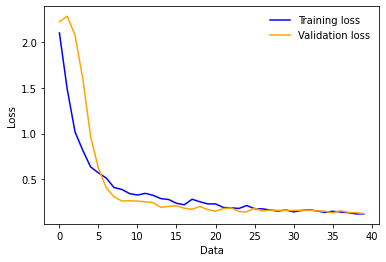

-> Test Results for Fold - 4


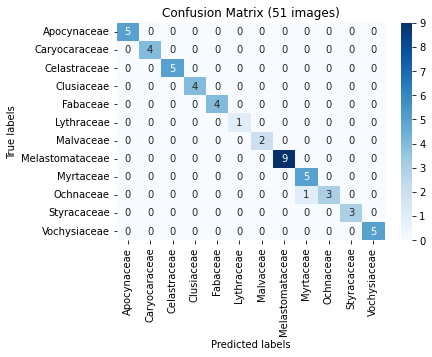

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  100.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  75.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  4  Test Accuracy:  98.0392156862745 %
--------------------------------
FOLD 5
-> Training Results for Fold - 5
Classes Accuracies:


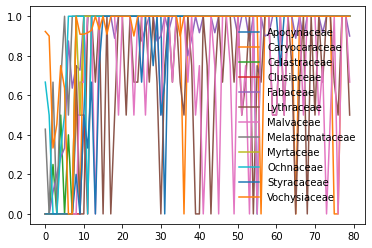

 Loss Curves:


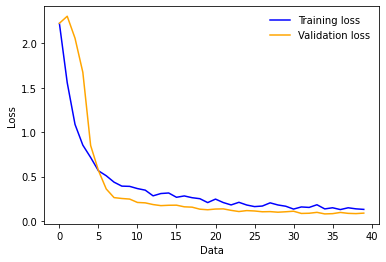

-> Test Results for Fold - 5


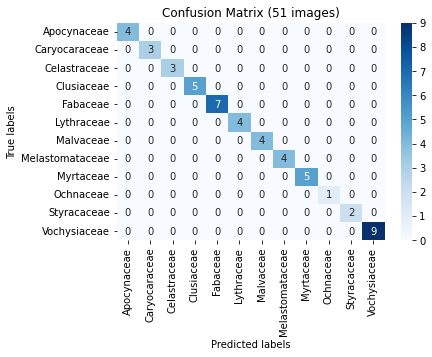

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  100.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  100.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  5  Test Accuracy:  100.0 %
--------------------------------
FOLD 6
-> Training Results for Fold - 6
Classes Accuracies:


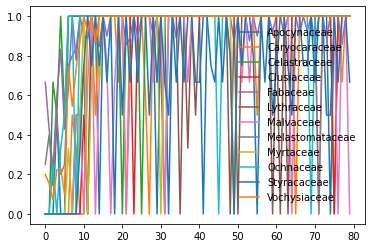

 Loss Curves:


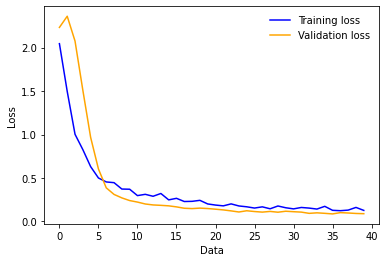

-> Test Results for Fold - 6


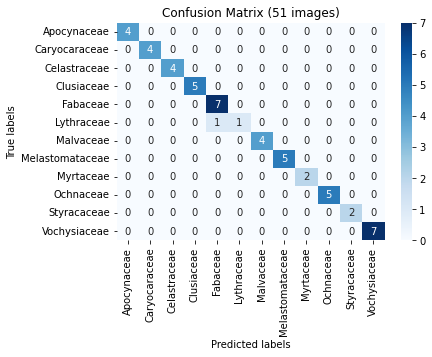

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  50.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  100.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  6  Test Accuracy:  98.0392156862745 %
--------------------------------
FOLD 7
-> Training Results for Fold - 7
Classes Accuracies:


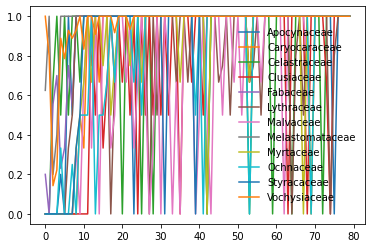

 Loss Curves:


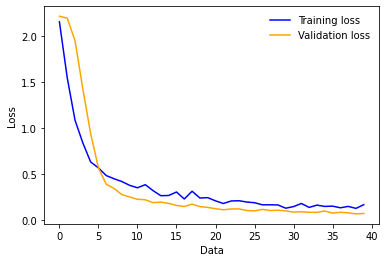

-> Test Results for Fold - 7


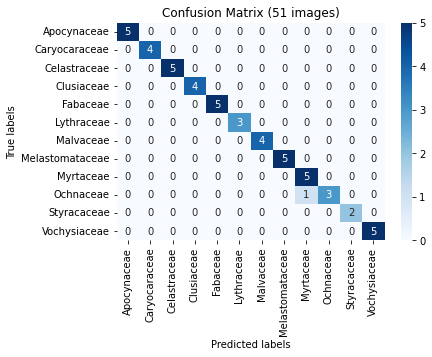

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  100.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  75.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  7  Test Accuracy:  98.0392156862745 %
--------------------------------
FOLD 8
-> Training Results for Fold - 8
Classes Accuracies:


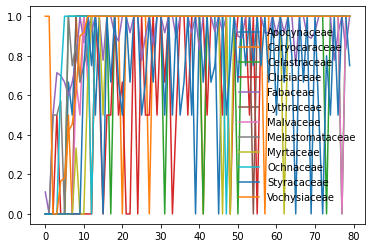

 Loss Curves:


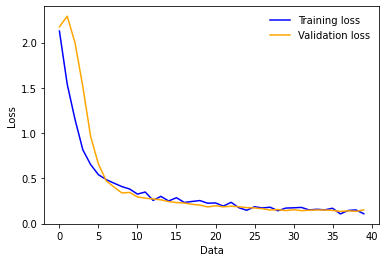

-> Test Results for Fold - 8


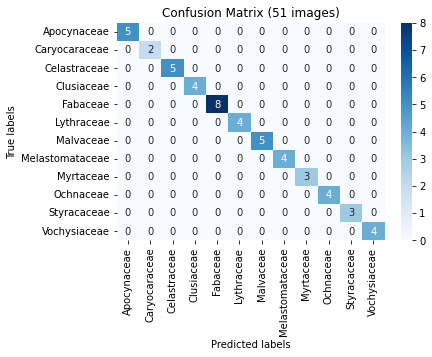

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  100.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  100.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  8  Test Accuracy:  100.0 %
--------------------------------
FOLD 9
-> Training Results for Fold - 9
Classes Accuracies:


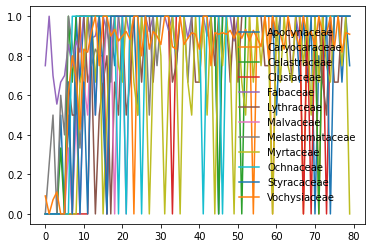

 Loss Curves:


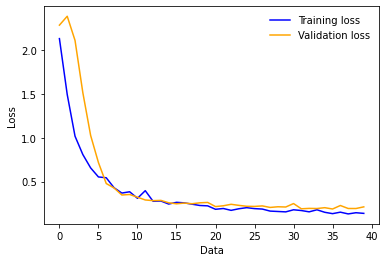

-> Test Results for Fold - 9


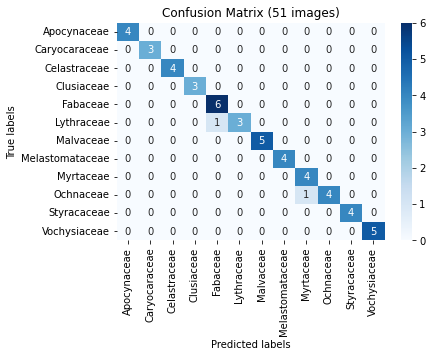

Test accuracy average for class  Apocynaceae  -  100.0 %
Test accuracy average for class  Caryocaraceae  -  100.0 %
Test accuracy average for class  Celastraceae  -  100.0 %
Test accuracy average for class  Clusiaceae  -  100.0 %
Test accuracy average for class  Fabaceae  -  100.0 %
Test accuracy average for class  Lythraceae  -  75.0 %
Test accuracy average for class  Malvaceae  -  100.0 %
Test accuracy average for class  Melastomataceae  -  100.0 %
Test accuracy average for class  Myrtaceae  -  100.0 %
Test accuracy average for class  Ochnaceae  -  80.0 %
Test accuracy average for class  Styracaceae  -  100.0 %
Test accuracy average for class  Vochysiaceae  -  100.0 %
Fold -  9  Test Accuracy:  96.07843137254902 %
--------------------------------


In [8]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score

class_acc = []
fold_acc_avg = {}
classes_acc = {}
all_classes_acc = {}
fold_preds = {}
fold_trues = {}
all_train_losses = []
all_valid_losses = []
all_trues =[]
all_preds =[]

print('--------------------------------')

# getting the labels of the images from the training set for stratified split
train_labels=[]
for i in range(len(train_set)):
       train_labels.append(train_set[i][1])

# Stratified K-fold split
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)

# K-fold Cross Validation model evaluation
for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset_kfold, train_labels)):
    print(f'FOLD {fold}')
    
    # Sample elements randomly from a list of ids, no replacement
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
    
    # Define data loaders for training and validation data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset_kfold, 
                      batch_size=batch_size, sampler=train_subsampler)
    
    validloader = torch.utils.data.DataLoader(
                      dataset_kfold,
                      batch_size=batch_size, sampler=valid_subsampler)
    
    divide = int(len(trainloader)/len(validloader))
    
    # Call "restart_network()" function to get a new network (reset weights)
    network = restart_network()
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.fc.parameters(), lr=0.1/batch_size)
    
    fold_train_losses = []
    fold_valid_losses = []
    fold_classes_accuracies = []
    fold_true =[]
    fold_pred=[]
    
    for epoch in range(num_epochs):
        step = 0
        train_losses, valid_losses, classes_accuracies = train_epoch(network, trainloader, validloader, optimizer, loss_function, divide, classes)      
        
        # Evaluation for this fold
        fold_train_losses += train_losses
        
        fold_valid_losses += valid_losses
        
        fold_classes_accuracies += classes_accuracies
        
    print("-> Training Results for Fold - " + str(fold))
    
    # Plot classes accuracies
    print('Classes Accuracies:')
    df = pd.DataFrame(fold_classes_accuracies)
    for classname in classes:
        classes_acc[classname] = df[classname]
        plt.plot(df[classname], label= classname)
    plt.legend(frameon=False)
    
    plt.savefig(f'./fold-{fold}-classes_accuracies.png')
    plt.show()
    
    print(' Loss Curves:')
    df_train = pd.DataFrame(fold_train_losses)
    df_valid = pd.DataFrame(fold_valid_losses)
    plt.plot(df_train, 'blue', label='Training loss')
    plt.plot(df_valid, 'orange', label='Validation loss')
    plt.legend(frameon=False)
    
    plt.xlabel("Data")
    plt.ylabel("Loss")
    
    plt.savefig(f'./fold-{fold}-loss.png')
    plt.show()
    
    # Saving the model
    save_path = f'./fold-{fold}-model.pth'
    torch.save(network.state_dict(), save_path)
    
    print("-> Test Results for Fold - " + str(fold))
    nome = 'fold-' + str(fold) + '-model.pth'
    modelo_teste=network
    
    test_true, test_pred = test(modelo_teste, classes)
    
    # Generate Confusion Matrix
    cf_matrix = confusion_matrix(test_true, test_pred)
    cf_matrix_n = cf_matrix.astype('int')
    x = plt.subplot()
    
    df_cm = pd.DataFrame(cf_matrix_n, index = [i for i in classes], columns = [i for i in classes])
    
    sn.heatmap(df_cm, cmap='Blues', ax=x, annot=True, fmt="d")
    x.set_xlabel('Predicted labels');x.set_ylabel('True labels'); 
    titulo = 'Confusion Matrix ('+ str(len(test_true)) + ' images)'
    x.set_title(titulo); 
    
    plt.savefig(f'fold-{fold}-confusion.png')
    plt.show()
    
    cf_matrix_acc = cf_matrix.astype('int') / cf_matrix.sum(axis=1)
    e = 0
    for classname in classes:
        print("Test accuracy average for class ", classname, " - ", (100*cf_matrix_acc.diagonal()[e]), "%")
        e+=1 
        
    test_acc = accuracy_score(test_true, test_pred)
    print('Fold - ',fold, ' Test Accuracy: ', 100*test_acc, "%")
    
    print('--------------------------------')
    
    # Saving general results
    fold_acc_avg[fold] = test_acc
    all_classes_acc[fold] = classes_acc
    if all_train_losses == []:
        all_train_losses = np.zeros_like(fold_train_losses)
        all_valid_losses = np.zeros_like(fold_valid_losses)
        
    all_train_losses = np.add(all_train_losses, fold_train_losses) 
    all_valid_losses = np.add(all_valid_losses, fold_valid_losses) 
    
    all_trues += test_true
    all_preds += test_pred
    
    fold_preds[fold] = test_pred
    fold_trues[fold] = test_true

## Final Results
* generate average training results (all folds)
* generate average testing results (all folds)
* print again the training results for all folds (for organization and visualization purposes)

---------------------------------------------
Average Training Results: 
 size train loader:  17  batches
 size valid loader:  2  batches
---------------------------------------------
Accuracy per class: 


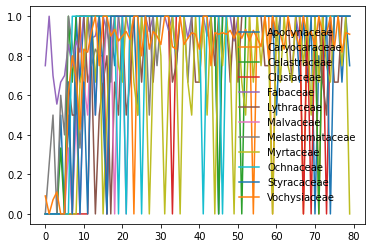

 
Average Losses: 


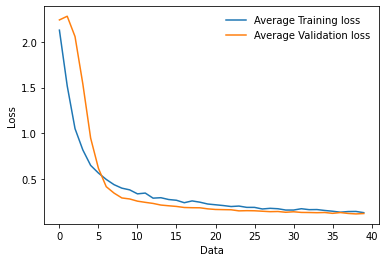

---------------------------------------------
Average Testing Results: 
---------------------------------------------
General confusion matrix: 
batch de  51  imagens utilizado em  10 testes (1 para cada fold)
Total de imagens:  510


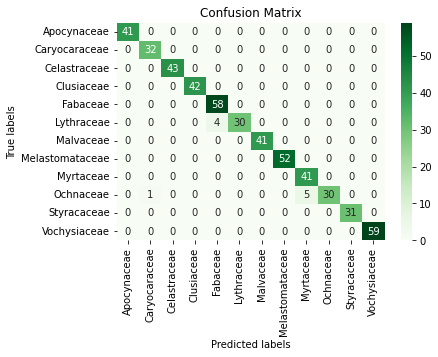

 
Testing Accuracy Averages (all folds): 
for class  Apocynaceae  -  100.0 %
for class  Caryocaraceae  -  100.0 %
for class  Celastraceae  -  100.0 %
for class  Clusiaceae  -  100.0 %
for class  Fabaceae  -  100.0 %
for class  Lythraceae  -  88.23529411764706 %
for class  Malvaceae  -  100.0 %
for class  Melastomataceae  -  100.0 %
for class  Myrtaceae  -  100.0 %
for class  Ochnaceae  -  83.33333333333334 %
for class  Styracaceae  -  100.0 %
for class  Vochysiaceae  -  100.0 %
general average accuracy:  98.0392156862745 %


In [9]:
# Gráfico médio das acurácias para cada classe

from collections import defaultdict
print("---------------------------------------------")
print("Average Training Results: ")
print(" size train loader: ", len(trainloader), " batches")
print(" size valid loader: ", len(validloader), " batches")
print("---------------------------------------------")
print("Accuracy per class: ")

for classname in classes:
    class_acc_points = []
    class_acc_sum = defaultdict(list)
    class_acc_plot = []

    for i in range(len(classes_acc[classname])):
        for j in range(k_folds):
            class_acc_item = all_classes_acc[j][classname][i]
            for f in range(k_folds):
                if j == f:
                    class_acc_sum[i].append(all_classes_acc[j][classname][i])
        class_acc_points = np.sum(class_acc_sum[i])/k_folds
            
        class_acc_plot.append(class_acc_points)   
    acc = pd.DataFrame(class_acc_plot)
    plt.plot(class_acc_plot, label= classname)

plt.legend(frameon=False)
plt.savefig(f'./final_avg_classes_accuracies.png')  
plt.show()

# generate average loss curves
print(" ")
print("Average Losses: ")
avg_train_loss = all_train_losses/k_folds
avg_valid_loss = all_valid_losses/k_folds

plt.plot(avg_train_loss, label='Average Training loss')
plt.plot(avg_valid_loss, label='Average Validation loss')
plt.legend(frameon=False)
    
plt.xlabel("Data")
plt.ylabel("Loss")
    
plt.savefig(f'./final_avg_loss.png')
plt.show()

print("---------------------------------------------")
print("Average Testing Results: ")
print("---------------------------------------------")
#Gerar matriz de confusão média:
print("General confusion matrix: ")
print("batch de ", batch_size, " imagens utilizado em ", k_folds, "testes (1 para cada fold)")
print("Total de imagens: ", batch_size*k_folds)
cf_avg_matrix = confusion_matrix(all_trues, all_preds)

cf_avg_matrix = cf_avg_matrix.astype('int') #/ cf_matrix.sum(axis=1)
x = plt.subplot()
    
df_cm = pd.DataFrame(cf_avg_matrix, index = [i for i in classes], columns = [i for i in classes])
    
sn.heatmap(df_cm, cmap='Greens', ax=x, annot=True, fmt="d")
x.set_xlabel('Predicted labels');x.set_ylabel('True labels'); 
x.set_title('Confusion Matrix'); 
    
plt.savefig(f'final-confusion_matrix.png')
plt.show()

print(" ")
print("Testing Accuracy Averages (all folds): ")
cf_avg_matrix2 = confusion_matrix(all_trues, all_preds)
cf_avg_matrix2 = cf_avg_matrix2.astype('float') / cf_avg_matrix2.sum(axis=1)
c = 0
for classname in classes:
    print("for class ", classname, " - ", (100*cf_avg_matrix2.diagonal()[c]), "%")
    c+=1 
        
training_avg_acc = accuracy_score(all_trues, all_preds)
print('general average accuracy: ', 100*training_avg_acc, "%")
    

In [10]:
# Print average training Results for every fold
print(" ")
print("Average Training percentages per fold: ")

for f in range(k_folds):
    print('---------------------------------')
    print("Fold - ", f)
    print('-----------')
    print("Training Accuracy Averages: ")
    cf_avg_matrix2 = confusion_matrix(fold_trues[f], fold_preds[f])
    cf_avg_matrix2 = cf_avg_matrix2.astype('float') / cf_avg_matrix2.sum(axis=1)
    c = 0
    for classname in classes:
        print("for class ", classname, " - ", (100*cf_avg_matrix2.diagonal()[c]), "%")
        c+=1 
        
    training_avg_acc = accuracy_score(fold_trues[f], fold_preds[f])
    print('general average accuracy: ', 100*training_avg_acc, "%")

 
Average Training percentages per fold: 
---------------------------------
Fold -  0
-----------
Training Accuracy Averages: 
for class  Apocynaceae  -  100.0 %
for class  Caryocaraceae  -  100.0 %
for class  Celastraceae  -  100.0 %
for class  Clusiaceae  -  100.0 %
for class  Fabaceae  -  100.0 %
for class  Lythraceae  -  66.66666666666666 %
for class  Malvaceae  -  100.0 %
for class  Melastomataceae  -  100.0 %
for class  Myrtaceae  -  100.0 %
for class  Ochnaceae  -  75.0 %
for class  Styracaceae  -  100.0 %
for class  Vochysiaceae  -  100.0 %
general average accuracy:  96.07843137254902 %
---------------------------------
Fold -  1
-----------
Training Accuracy Averages: 
for class  Apocynaceae  -  100.0 %
for class  Caryocaraceae  -  100.0 %
for class  Celastraceae  -  100.0 %
for class  Clusiaceae  -  100.0 %
for class  Fabaceae  -  100.0 %
for class  Lythraceae  -  100.0 %
for class  Malvaceae  -  100.0 %
for class  Melastomataceae  -  100.0 %
for class  Myrtaceae  -  100.0 %


## Saving images as .zip (if needed)

In [11]:
# Saving only images to .zip
#from zipfile import ZipFile
#import os

#zipObj = ZipFile('resnetRS_classification.zip', 'w')

#for filename in os.listdir("/kaggle/working/pytorch_resnet_rs"):
#    if filename.endswith(".png"):
#        zipObj.write(filename)
#zipObj.close()

In [12]:
# saving everything to .zip
#import shutil
#shutil.make_archive("species_pre-trained_resnet_rs50_15epochs_5folds", 'zip', "./")